# Simulación del benchmark Godiva con `OpenMC`

## Objetivo

Simular el reactor [Godiva](https://en.wikipedia.org/wiki/Godiva_device). Los detalles de este reactor pueden encontrarse en el benchmark HEU-MET-FAST-001 de [ICSBEP](https://www.oecd-nea.org/science/wpncs/icsbep/) y también en el sitio web de [Serpent](http://serpent.vtt.fi/mediawiki/index.php/Godiva_inputs). Godiva es una esfera de $8.7407$ cm de radio de uranio metálico de densidad $18.74$ gm/cm$^3$, $93.71$ % en peso de $^{235}$U, $5.27$ % en peso de $^{238}$U, y $1.02$ % en peso de $^{234}$U.

## Ayuda

Para realizar este benchmark, se debe tener un conocimiento básico de los comandos de `OpenMC`. En caso de tener dudas, el [notebook de ejemplo de la página oficial](https://docs.openmc.org/en/stable/examples/pincell.html) tiene todo lo necesario para empezar

Primero, debemos importar el módulo `openmc`

In [1]:
import openmc
import numpy as np
import os

In [2]:
openmc_data = "/home/agusgimenez/KD_OPMC/Secciones/endfb-vii.1-hdf5/cross_sections.xml"
os.environ["OPENMC_CROSS_SECTIONS"] = openmc_data
openmc.config['cross_sections'] = openmc_data

## Materiales

Generalmente, lo primero que se hace es cargar el listado de materiales mediante el módulo `openmc.Material()`

Para ello, se asigna dicho módulo a una variable cualquiera, por ejemplo `mat1=openmc.Material(name='mat1',material_id=1)`. Si bien los parámetros `name` y `material_id` son opcionales, ayudan en caso de tener que buscar un error de ejecución (si uno no asigna el `id` manualmente, cada vez que se ejecuta el notebook se asigna un nuevo valor).

Después, se van cargando uno a uno los elementos o los isótopos mediante los métodos `.add_element()` o `.add_nuclide()`, respectivamente. Los parámetros son: nombre del elemento/isótopo (símbolo químico más número másico), porcentaje y tipo de porcentaje (en peso `wo` o en átomos `ao`).

Recordar que, en caso de cargar un elemento, las abundancias isotópicas de cada isótopo corresponden a las abundancias naturales (para más info, se puede comparar los valores que tiene guardado `OpenMC` con `openmc.data.NATURAL_ABUNDANCE` con los de la tabla de los nucleídos). Ante la duda, conviene calcular a mano las densidades numéricas, y luego calcular los porcentajes relativos.

Luego de cargar todos los elementos/isótopos que posee un dado material, se debe asignar la densidad del material. Las unidades usuales son `g/cm³` y `atom/barn-cm`.

Para más información, usar la función `help` de `Python`.

Con los datos del benchmark, generamos un único material con la densidad y los porcentajes indicados

In [3]:
mat01 = openmc.Material(material_id = 1)
mat01.add_nuclide("U235", 0.9371, 'wo')
mat01.add_nuclide("U238", 0.0527, 'wo')
mat01.add_nuclide("U234", 0.0102, 'wo')
mat01.set_density("g/cm3", 18.74)

## Geometría

Luego, lo usual es generar la geometría del problema. Para ello, se deben generar regiones como intersección de superficies. Para más información, ver el [notebook de ejemplo de OpenMC](https://docs.openmc.org/en/stable/examples/pincell.html)

Una vez que tenemos todas las celdas necesarias, las asignamos a un universo mediante el módulo `openmc.Universe()`. 

En el caso de Godiva, tenemos solo una celda consistente en el interior de una esfera, la cual asignaremos a un universo

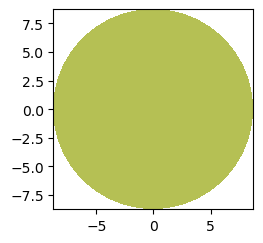

In [4]:
R01 = 8.7407

surf01 = openmc.Sphere(r = R01, boundary_type = "vacuum", surface_id = 1)
cell01 = openmc.Cell(region = -surf01, fill = mat01, cell_id = 1)
univ01 = openmc.Universe(cells = [cell01], universe_id = 1)

univ01.plot(width = (2*R01, 2*R01))

## Parámetros

Después, especificamos cuáles van a ser los parámetros de nuestra simulación: modo de corrida (`.mode`, 'eigenvalue' si es cálculo de criticidad, o 'fixed source' si es de fuente fija), número de partículas (`.particles`), número de batches (`.batches`), posición de la fuente (`.source`, por default, es centrada en el origen con un espectro de fisión Watt), si quiero que se simulen los fotones (`.photon_transport=True`), entre otros.

Para más información, ver `help(openmc.Settings)`

In [5]:
sets = openmc.Settings()
sets.run_mode = "eigenvalue"
sets.particles = 100
sets.batches = 110
sets.inactive = 10
sets.photon_transport = True

## Tallies

Por último, especifico si quiero simular "tallies" o contadores dentro de la geometría. Para este ejemplo en particular, vamos a ver el espectro energético en toda la esfera, y la distribución espacial del flujo a 1 grupo de energía (se podrían combinar las dos, por ejemplo, se puede ver la distribución espacial a 3 grupos de energía), tanto para los neutrones como para los fotones.

In [6]:
tallies = openmc.Tallies()

# Grilla
mesh_xy = openmc.RegularMesh(mesh_id = 1)
mesh_xy.lower_left = [-R01, -R01, -R01]
mesh_xy.upper_right = [R01, R01, R01]
mesh_xy.dimension = [100, 100, 1]

# Filtro de grilla
filter_mesh_xy = openmc.filter.MeshFilter(mesh_xy, filter_id = 1)

# Filtro de particulas
filter_neutron = openmc.ParticleFilter(['neutron'], filter_id = 2)
filter_photon = openmc.ParticleFilter(['photon'], filter_id = 3)

#Filtro de energías
filter_energy_neutron = openmc.filter.EnergyFilter(np.logspace(np.log10(1e-5), np.log10(2e7), 201),filter_id = 4)
filter_energy_photon = openmc.filter.EnergyFilter(np.linspace(0, 2e7, 201), filter_id = 5)

# Tallies
flux_neutron_xy = openmc.Tally(name = 'flux_neutron_xy', tally_id = 1)
flux_neutron_xy.scores = ["flux"]
flux_neutron_xy.filters = [filter_mesh_xy, filter_neutron]
tallies.append(flux_neutron_xy)

flux_photon_xy = openmc.Tally(name = 'flux_photon_xy',tally_id = 2)
flux_photon_xy.scores = ["flux"]
flux_photon_xy.filters = [filter_mesh_xy, filter_photon]
tallies.append(flux_photon_xy)

spectra_neutron = openmc.Tally(name = 'spectra_neutron', tally_id = 3)
spectra_neutron.scores = ['flux']
spectra_neutron.filters = [filter_energy_neutron, filter_neutron]
tallies.append(spectra_neutron)

spectra_photon = openmc.Tally(name='spectra_photon',tally_id = 4)
spectra_photon.scores = ['flux']
spectra_photon.filters = [filter_energy_photon, filter_photon]
tallies.append(spectra_photon)



## Gráficos (opcional)

En caso de querer gráficar la geometría modelada con el código, esto se realiza con el módulo `.plot`. En nuestro caso, es bastante sencilla la geometría.

In [7]:
plots = openmc.Plots()

plot_xy = openmc.Plot()
plot_xy.id = 1
plot_xy.basis = 'xy'
plot_xy.origin = (0,0,0)
plot_xy.width = (2*R01, 2*R01)
plot_xy.pixels = (100, 100)
plot_xy.color_by='material'
plots.append(plot_xy)

/home/agusgimenez/anaconda3/envs/KD_OPMC/lib/python3.9/site-packages/openmc/mixin.py:70: IDWarning: Another Plot instance already exists with id=1.
  warn(msg, IDWarning)


## Generación de los archivos `.xml`

Finalmente, generamos los archivos `.xml` necesarios para poder simular nuestro modelo

In [8]:
openmc_exec = 'openmc' # esto es por si tengo muchas versiones instaladas


geom = openmc.Geometry(univ01)
geom.export_to_xml()

mats = openmc.Materials(geom.get_all_materials().values()) # con este comando, me aseguro de exportar solo los materiales que aparecen en la geometría
mats.cross_sections = openmc_data
mats.export_to_xml()

sets.export_to_xml()

tallies.export_to_xml()

In [9]:
!rm summary.h5
openmc.run(openmc_exec=openmc_exec)

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

In [10]:
keff1=openmc.StatePoint('statepoint.110.h5').k_generation

!rm statepoint.110.h5
!rm summary.h5

sets = openmc.Settings()
sets.run_mode = "eigenvalue"
sets.particles = 1000
sets.batches = 110
sets.inactive = 10
sets.photon_transport = True
sets.export_to_xml()

openmc.run(openmc_exec=openmc_exec)

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

In [11]:
keff2=openmc.StatePoint('statepoint.110.h5').k_generation

!rm statepoint.110.h5
!rm summary.h5

sets = openmc.Settings()
sets.run_mode = "eigenvalue"
sets.particles = 10000
sets.batches = 110
sets.inactive = 10
sets.photon_transport = True
sets.export_to_xml()

openmc.run(openmc_exec=openmc_exec)

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

In [12]:
keff3=openmc.StatePoint('statepoint.110.h5').k_generation

In [13]:
import matplotlib.pyplot as plt

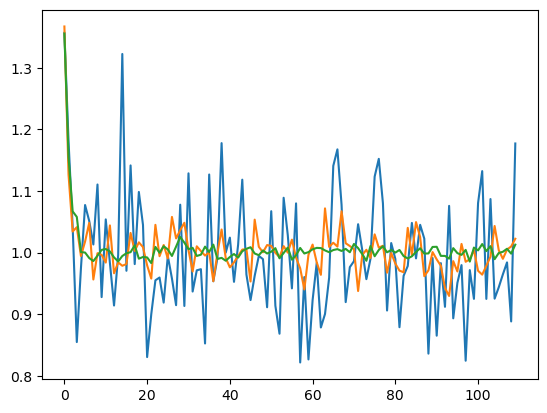

In [14]:
plt.plot(keff1)
plt.plot(keff2)
plt.plot(keff3)

## Procesamiento de tallies

In [15]:
sp=openmc.StatePoint('statepoint.110.h5')      #abro el statepoint
S0=1.0 #[n/s]

Los tallies de flujo tienen como unidad de salida [part cm/src]. Cómo hago para llevar esto a las unidades usuales de [n/cm² s]?

### Caso de distribución espacial:

Para obtener el flujo espacial a 1 grupo en n/(cm² s), tengo que dividir cada celda de la grilla por su respectivo volumen y multiplicar por la fuente total en n/s

In [16]:
from matplotlib.colors import LogNorm

100 -8.7407 8.7407 17.4814
100 -8.7407 8.7407 17.4814
1 -8.7407 8.7407 17.4814
0.174814 0.174814 17.4814


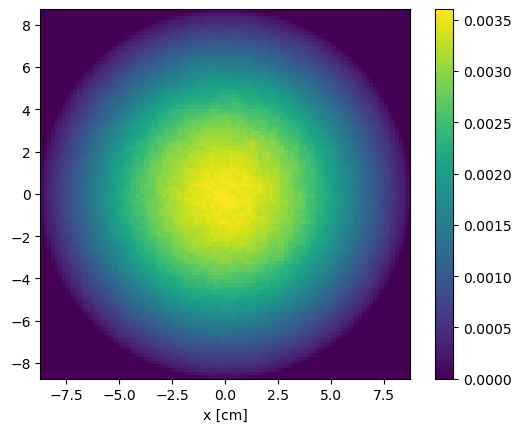

In [17]:
tally=sp.get_tally(name='flux_neutron_xy')       
mesh_filter=tally.find_filter(openmc.filter.MeshFilter)
data=tally.get_slice(scores=['flux'])

Nx=mesh_filter.mesh.dimension[0]
xmin=mesh_filter.mesh.lower_left[0]
xmax=mesh_filter.mesh.upper_right[0]
dx=xmax-xmin

print(Nx, xmin, xmax, dx)

Ny=mesh_filter.mesh.dimension[1]
ymin=mesh_filter.mesh.lower_left[1]
ymax=mesh_filter.mesh.upper_right[1]
dy=ymax-ymin

print(Ny, ymin, ymax, dy)

Nz=mesh_filter.mesh.dimension[2]
zmin=mesh_filter.mesh.lower_left[2]
zmax=mesh_filter.mesh.upper_right[2]
dz=zmax-zmin

print(Nz, zmin, zmax, dz)

data.mean.shape=(Nx,Ny)
data.std_dev.shape=(Nx,Ny)

data_mean = data.mean*S0/(dx/Nx*dy/Ny*dz/Nz)
data_stdv = data.std_dev*S0/(dx/Nx*dy/Ny*dz/Nz)


print(dx/Nx, dy/Ny, dz/Nz)


plt.imshow(data_mean, origin='lower', interpolation='none', extent=(xmin,xmax,ymin,ymax), cmap='viridis')
plt.colorbar()
plt.xlabel('x [cm]')
plt.show()

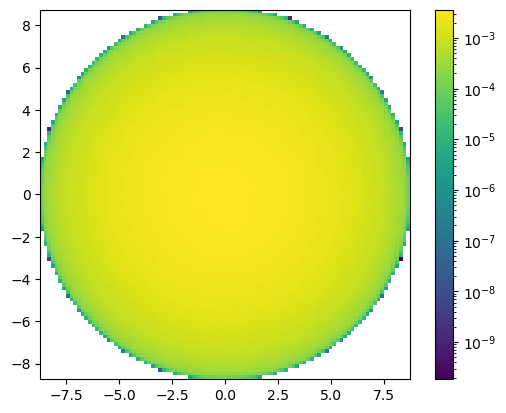

In [18]:
plt.imshow(data_mean,origin='lower',interpolation='none',extent=(xmin,xmax,ymin,ymax),cmap='viridis',norm=LogNorm())
plt.colorbar()
plt.show()

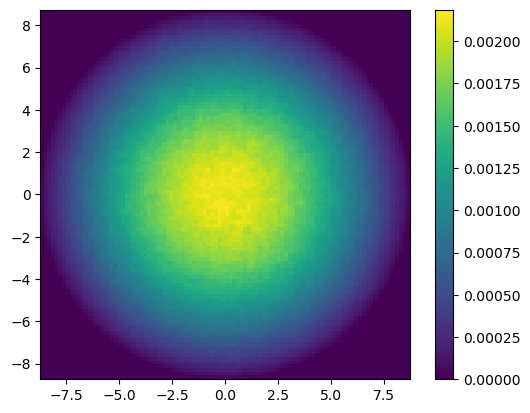

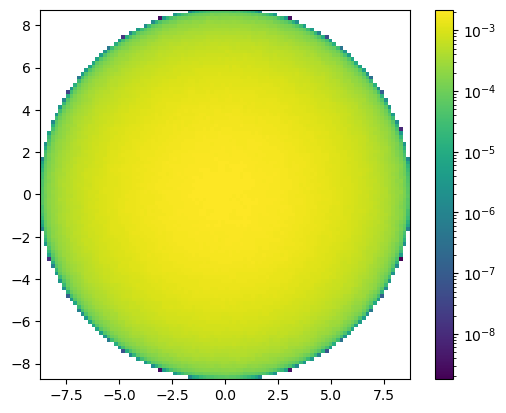

In [19]:
tally=sp.get_tally(name='flux_photon_xy')       
mesh_filter=tally.find_filter(openmc.filter.MeshFilter)
data=tally.get_slice(scores=['flux'])

Nx=mesh_filter.mesh.dimension[0]
xmin=mesh_filter.mesh.lower_left[0]
xmax=mesh_filter.mesh.upper_right[0]
dx=xmax-xmin

Ny=mesh_filter.mesh.dimension[1]
ymin=mesh_filter.mesh.lower_left[1]
ymax=mesh_filter.mesh.upper_right[1]
dy=ymax-ymin

Nz=mesh_filter.mesh.dimension[2]
zmin=mesh_filter.mesh.lower_left[2]
zmax=mesh_filter.mesh.upper_right[2]
dz=zmax-zmin

data.mean.shape=(Nx,Ny)
data.std_dev.shape=(Nx,Ny)

data_mean=data.mean*S0/(dx/Nx*dy/Ny*dz/Nz)
data_stdv=data.std_dev*S0/(dx/Nx*dy/Ny*dz/Nz)

plt.imshow(data_mean,origin='lower',interpolation='none',extent=(xmin,xmax,ymin,ymax),cmap='viridis')
plt.colorbar()
plt.show()

plt.imshow(data_mean,origin='lower',interpolation='none',extent=(xmin,xmax,ymin,ymax),cmap='viridis',norm=LogNorm())
plt.colorbar()
plt.show()

### Caso de distribución energética

Para obtener el espectro en todo el espacio en n/(cm² s eV), tengo que dividir por el volumen total y por el ancho del bin energético y multiplicar por la fuente en n/s

In [20]:
dV = 4/3*np.pi*R01**3

data = sp.get_tally(name='spectra_neutron').get_pandas_dataframe(nuclides=False)
data.columns = ['Emin','Emax','particle','score','mean','stdv']
Emin = data['Emin'].values
Emax = data['Emax'].values
E = (Emin+Emax)/2.0
dE = Emax-Emin

data_mean = data['mean']*S0/(dE*dV)
data_stdv = data['stdv']*S0/(dE*dV)

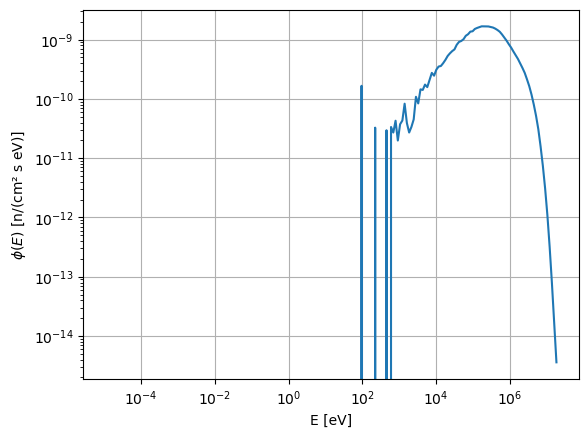

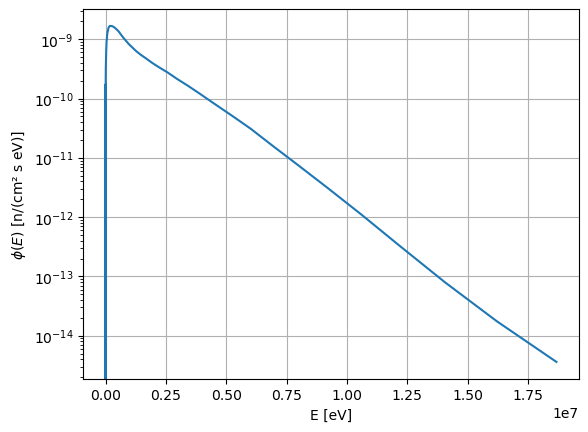

In [21]:



plt.loglog(E,data_mean)
plt.xlabel('E [eV]')
plt.ylabel('$\phi(E)$ [n/(cm² s eV)]')
plt.grid()
plt.show()

plt.semilogy(E,data_mean)
plt.xlabel('E [eV]')
plt.ylabel('$\phi(E)$ [n/(cm² s eV)]')
plt.grid()
plt.show()

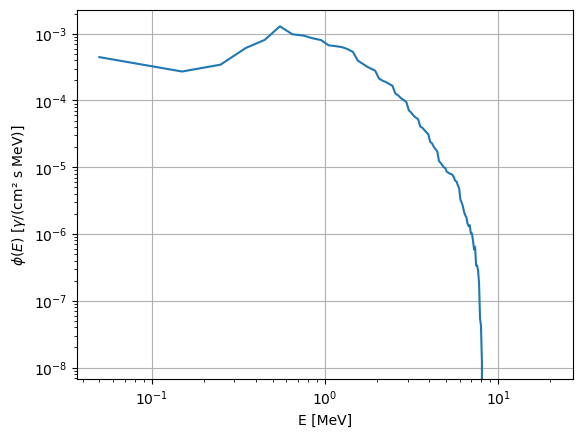

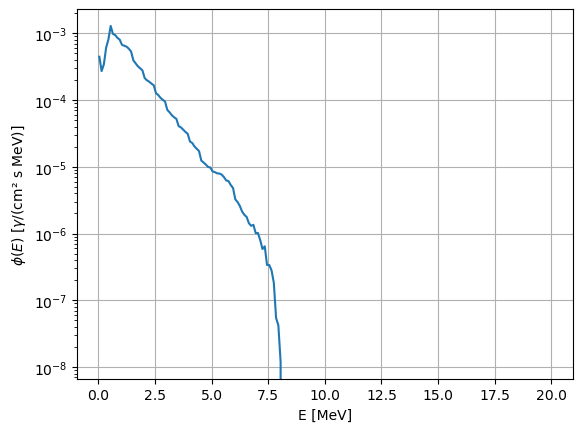

In [22]:
data=sp.get_tally(name='spectra_photon').get_pandas_dataframe(nuclides=False)
data.columns=['Emin','Emax','particle','score','mean','stdv']
Emin=data['Emin'].values
Emax=data['Emax'].values
E=(Emin+Emax)/2.0
dE=Emax-Emin

data_mean=data['mean']*S0/(dE*dV)
data_stdv=data['stdv']*S0/(dE*dV)

plt.loglog(E*1e-6,data_mean*1e6)
plt.xlabel('E [MeV]')
plt.ylabel('$\phi(E)$ [$\gamma$/(cm² s MeV)]')
plt.grid()
plt.show()

plt.semilogy(E*1e-6,data_mean*1e6)
plt.xlabel('E [MeV]')
plt.ylabel('$\phi(E)$ [$\gamma$/(cm² s MeV)]')
plt.grid()
plt.show()